In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import scipy.stats
from pybedtools import BedTool
import pickle
from tqdm import tqdm
from pyfaidx import Fasta

from seq2atac.stable import compute_gc_bed, one_hot_encode, read_pickle, compute_signal, write_pickle
from seq2atac.analysis import get_promoterai_tss, get_cosmic_pancan_genes, fasta_file
from seq2atac.analysis.enrichment_utils import create_pancancer_distribution_plots, create_pancancer_correlations, create_pancancer_valuecounts, create_pancancer_distribution_plots_discrete
from seq2atac.analysis.sample_controls import matching_logic
from seq2atac.analysis.mutation_utils import compute_vierstra_groups, compute_trinuc, ingene_indicator
from seq2atac.analysis.mutation_processing_pipeline_utils import annotateNearestGene, annotateScore, filterannotatePeaks, annotatePhylopScore, annotatePhylopScorePeak, annotateBedfile

/home/akumar22/anaconda3/envs/python38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
somatic_df_dict = read_pickle("somatic_df_dict_lof.pkl")
pancan_matched_dict = read_pickle("pancan_matched_dict_ogtsg.pkl")
nonpancan_matched_dict = read_pickle("nonpancan_matched_dict_ogtsg.pkl")
all_tcga_cancers = ["BLCA","BRCA","GBM","COAD","KIRC","KIRP","LUAD"]
ism_thresh = read_pickle("../process_tcga_icgc/ism_thresh_percentile.pkl")[95]
ism_thresh

{'brca': 0.17696281257796992,
 'blca': 0.2097989422114596,
 'coad': 0.19172578644761995,
 'luad': 0.27739862176416474,
 'kirp': 0.23343622358881733,
 'kirc': 0.2235218676975348,
 'gbm': 0.21235916285438658,
 'skcm': 0.19640249133953247}

In [3]:
### total number of somatic mutations - before matching
total = 0
for cancer_name in all_tcga_cancers:
    
    print(cancer_name)
    somatic_df = somatic_df_dict[cancer_name].copy()
    total += len(somatic_df)
    print(len(somatic_df))
total

BLCA
13593
BRCA
36972
GBM
4732
COAD
39782
KIRC
7984
KIRP
3495
LUAD
16028


122586

In [4]:
### total number of donors in the somatic set
total_donors = 0
donor_list = []
for cancer_name in all_tcga_cancers:
    
    print(cancer_name)
    somatic_df = somatic_df_dict[cancer_name].copy()
    unq_donors_list = list(somatic_df["Donor_ID"].unique())
    donor_list += unq_donors_list
    unq_donors = len(unq_donors_list)
    total_donors += unq_donors
    print(unq_donors)
total_donors, len(set(donor_list))

BLCA
23
BRCA
198
GBM
41
COAD
37
KIRC
111
KIRP
33
LUAD
38


(481, 481)

In [5]:
### total relevant donors before filtering (7 cancers)
total_donors = 0
donor_list = []
for cancer_name in all_tcga_cancers:
    
    print(cancer_name)
    somatic_df = read_pickle(f"/illumina/scratch/deep_learning/akumar22/TCGA/mutation_prioritization/cancer_specific_somatic_hg38/{cancer_name}_somatic_hg38.pkl")
    unq_donors_list = list(somatic_df["Donor_ID"].unique())
    donor_list += unq_donors_list
    unq_donors = len(unq_donors_list)
    total_donors += unq_donors
    print(unq_donors)
total_donors, len(set(donor_list))

BLCA
23
BRCA
198
GBM
41
COAD
37
KIRC
111
KIRP
33
LUAD
38


(481, 481)

In [6]:
all_mutations = []
for cancer_name in all_tcga_cancers:
    
    
    somatic_df = somatic_df_dict[cancer_name].copy()
    threshold = somatic_df["diff_summit_centered"].quantile(0.975)
    ism_es = ism_thresh[cancer_name.lower()]

    print(cancer_name, threshold, ism_es)
    
    pancan_df = pancan_matched_dict[cancer_name].copy()
    pancan_df["sample"] = pancan_df["sample"].apply(lambda x : x.upper())
    pancan_df["prioritized"] = 0
    indices = pancan_df[(pancan_df["diff_summit_centered"]>threshold) & (pancan_df["ref"] > ism_es) & (pancan_df["ref-mut"] > 0)].index
    pancan_df.loc[indices,"prioritized"] = 1
    indices = pancan_df[(pancan_df["diff_summit_centered"]>threshold)].index
    pancan_df.loc[indices,"prioritized_noism"] = 1

    
    nonpancan_df = nonpancan_matched_dict[cancer_name].copy()
    nonpancan_df["sample"] = nonpancan_df["sample"].apply(lambda x : x.upper())
    nonpancan_df["prioritized"] = 0
    indices = nonpancan_df[(nonpancan_df["diff_summit_centered"]>threshold) & (nonpancan_df["ref"] > ism_es) & (nonpancan_df["ref-mut"] > 0)].index
    nonpancan_df.loc[indices,"prioritized"] = 1
    indices = nonpancan_df[(nonpancan_df["diff_summit_centered"]>threshold)].index
    nonpancan_df.loc[indices,"prioritized_noism"] = 1
    
    all_mutations.append(pancan_df)
    all_mutations.append(nonpancan_df)
    
all_mutations = pd.concat(all_mutations, axis=0, ignore_index=True)
all_mutations = all_mutations.sort_values(["Chromosome","hg38_start","sample"]).reset_index(drop=True)

all_mutations



BLCA 0.047121298313140714 0.2097989422114596
BRCA 0.046678137779235754 0.17696281257796992
GBM 0.0649726867675781 0.21235916285438658
COAD 0.04962486773729317 0.19172578644761995
KIRC 0.046412371098995216 0.2235218676975348
KIRP 0.05527774393558505 0.23343622358881733
LUAD 0.0665462560951709 0.27739862176416474


,Chromosome,hg38_start,hg38_end,Tumor_Seq_Allele2,mutation_id,ctcf_uncleaned,peak_chr,peak_summit,peak_start,peak_end,...,sample,mut,ref,ref-mut,closest_ogtsg,gc_2,gc_1,distance_to_summit_discrete,prioritized,prioritized_noism
0,chr1,978707,978708,C,26,0,chr1,978780,978530,979030,...,LUAD,0.172975,0.186169,0.013194,0,0.68,0.7,70,0,NaN
1,chr1,1552046,1552047,G,181,0,chr1,1552200,1551950,1552450,...,BRCA,-0.064508,-0.008160,0.056349,0,0.59,0.6,150,0,NaN
2,chr1,2127530,2127531,A,165,0,chr1,2127518,2127268,2127768,...,GBM,0.435889,0.356885,-0.079004,0,0.61,0.6,10,0,NaN
3,chr1,2193610,2193611,C,414,0,chr1,2193507,2193257,2193757,...,BRCA,0.018371,0.062991,0.044620,0,0.61,0.6,100,0,NaN
4,chr1,2224737,2224738,A,226,0,chr1,2224933,2224683,2225183,...,BLCA,-0.774536,0.005234,0.779770,1,0.58,0.6,200,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15337,chr9,137396336,137396337,C,1093147,0,chr9,137396397,137396147,137396647,...,LUAD,-0.060694,1.122884,1.183578,0,0.58,0.6,60,1,1.0
15338,chr9,137405668,137405669,A,4959494,0,chr9,137405791,137405541,137406041,...,COAD,-0.265868,-0.185964,0.079904,0,0.57,0.6,120,0,NaN
15339,chr9,137436398,137436399,A,412362,0,chr9,137436200,137435950,137436450,...,BLCA,-0.163534,-0.187652,-0.024118,0,0.68,0.7,200,0,NaN
15340,chr9,137555968,137555969,G,4959608,0,chr9,137556155,137555905,137556405,...,COAD,0.400671,0.451839,0.051168,0,0.57,0.6,190,0,NaN


In [8]:
### some gene level analysis

<AxesSubplot:>

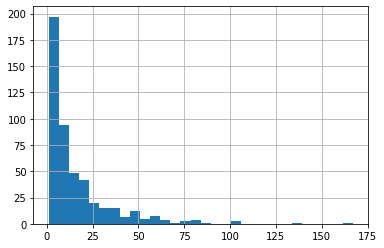

In [7]:
all_mutations[all_mutations["closest_pancan"]==1]["gene"].value_counts().hist(bins=30)

In [9]:
gene_counts_all = all_mutations[all_mutations["closest_pancan"]==1]["gene"].value_counts().reset_index()
gene_counts_all = gene_counts_all.sort_values("gene",ascending=False)
gene_counts_all

,index,gene
0,MYC,167
1,PBX1,139
2,EGFR,101
3,GATA3,101
4,CSMD3,101
...,...,...
450,N4BP2,1
451,DEK,1
452,DAXX,1
453,RHOA,1


In [10]:
gene_counts = all_mutations[(all_mutations["closest_pancan"]==1) &
                            (all_mutations["prioritized"] == 1)]["gene"].value_counts().reset_index()
gene_counts = gene_counts.sort_values("gene",ascending=False)
gene_counts

,index,gene
0,FOXO3,3
2,CSMD3,3
1,RAD51B,3
10,HLF,2
16,KLF6,2
...,...,...
40,NCOA2,1
39,RUNX1T1,1
38,CDH17,1
37,RSPO2,1


In [15]:
all_mutations[all_mutations["closest_pancan"]==1]

,Chromosome,hg38_start,hg38_end,Tumor_Seq_Allele2,mutation_id,ctcf_uncleaned,peak_chr,peak_summit,peak_start,peak_end,...,sample,mut,ref,ref-mut,closest_ogtsg,gc_2,gc_1,distance_to_summit_discrete,prioritized,prioritized_noism
4,chr1,2224737,2224738,A,226,0,chr1,2224933,2224683,2225183,...,BLCA,-0.774536,0.005234,0.779770,1,0.58,0.6,200,0,NaN
5,chr1,2225087,2225088,A,769,0,chr1,2224934,2224684,2225184,...,COAD,0.069757,0.006673,-0.063084,1,0.58,0.6,150,0,NaN
6,chr1,2225137,2225138,T,227,0,chr1,2224933,2224683,2225183,...,BLCA,0.051985,0.079359,0.027374,1,0.58,0.6,200,0,NaN
7,chr1,2225273,2225274,A,770,0,chr1,2225456,2225206,2225706,...,COAD,0.004202,0.023176,0.018974,1,0.56,0.6,180,0,NaN
8,chr1,2230103,2230104,A,186,0,chr1,2229926,2229676,2230176,...,GBM,0.136920,-0.018910,-0.155830,1,0.65,0.7,180,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15328,chr9,136596295,136596296,G,141820,0,chr9,136596439,136596189,136596689,...,KIRP,0.223892,0.023210,-0.200682,1,0.54,0.5,140,0,NaN
15329,chr9,136596664,136596665,T,4959145,0,chr9,136596725,136596475,136596975,...,COAD,0.028091,0.030819,0.002728,1,0.57,0.6,60,0,NaN
15330,chr9,136596796,136596797,A,4959146,0,chr9,136596725,136596475,136596975,...,COAD,0.006363,0.070656,0.064293,1,0.57,0.6,70,0,NaN
15331,chr9,136599296,136599297,A,1093033,0,chr9,136599141,136598891,136599391,...,LUAD,-0.097298,-0.145425,-0.048127,1,0.68,0.7,160,0,NaN


In [12]:
all_counts = {}
for idx,row in gene_counts.iterrows():
    gene = row["index"]
    tots = gene_counts_all[gene_counts_all["index"]==gene]["gene"]
    assert len(tots) == 1
    tots = tots.iloc[0]
    print(tots)
    priorit = row["gene"]
    print(priorit)
    nr = priorit/tots
    dr = 113/7558
    
    fisher_matrix = [[priorit,tots-priorit],[113,7558]]
    fc, pval = scipy.stats.fisher_exact(fisher_matrix)
    all_counts[gene] = (fc,pval)

39
3
101
3
50
3
16
2
85
2
29
2
139
2
43
2
36
2
48
2
25
2
62
2
59
2
79
2
27
2
167
2
31
2
57
2
27
1
10
1
20
1
14
1
101
1
5
1
13
1
16
1
9
1
10
1
49
1
58
1
78
1
63
1
29
1
41
1
9
1
24
1
37
1
46
1
33
1
6
1
8
1
52
1
79
1
56
1
47
1
53
1
18
1
19
1
74
1
22
1
33
1
38
1
14
1
19
1
17
1
28
1
19
1
67
1
30
1
4
1
8
1
8
1
20
1
18
1
34
1
79
1
10
1
57
1
21
1
50
1
68
1
3
1
52
1
60
1
60
1
21
1
15
1
21
1
39
1
49
1
28
1
46
1
12
1
9
1
22
1
50
1
38
1
35
1
20
1
18
1
23
1
8
1


In [13]:
list(filter(lambda x : x[1][1] < 0.05, sorted(all_counts.items(), key=lambda x:-x[1][0])))

[('CNBP', (33.442477876106196, 0.0439129381271935)),
 ('HLF', (9.554993678887485, 0.02322106299646912)),
 ('FOXO3', (5.573746312684365, 0.020469304361960556)),
 ('RAD51B', (4.269252494822068, 0.03886667703370356))]

In [19]:
### sanity check - please check if the values are correct
l1 = all_mutations[(all_mutations["prioritized"]==1) & (all_mutations["closest_pancan"]==1)].shape[0]
l2 = all_mutations[(all_mutations["prioritized"]==0) & (all_mutations["closest_pancan"]==1)].shape[0]
l3 = all_mutations[(all_mutations["prioritized"]==1) & (all_mutations["closest_pancan"]==0)].shape[0]
l4 = all_mutations[(all_mutations["prioritized"]==0) & (all_mutations["closest_pancan"]==0)].shape[0]

fisher_matrix = [[l1,l2],[l3,l4]]
scipy.stats.fisher_exact(fisher_matrix)

(1.5142418629267003, 0.006473624241152715)

In [20]:
prioritized_pancan_mutations = all_mutations[(all_mutations["closest_pancan"]==1) & 
              (all_mutations["prioritized"]==1)]
prioritized_pancan_mutations.shape, len(prioritized_pancan_mutations["Donor_ID"].unique())

((113, 63), 69)

In [21]:
pancan_genes = read_pickle("../process_tcga_icgc/ogtsg.pkl")
len(pancan_genes)

565

In [22]:
pd.set_option('display.max_rows', 500)
gene_counts = all_mutations[(all_mutations["prioritized"]==1)]["gene"].value_counts().reset_index()
display(gene_counts)
top_genes = gene_counts[gene_counts["gene"]>1]["index"].unique()
display(top_genes)

prioritized_multigene = all_mutations[(all_mutations["prioritized"]==1) &
              (all_mutations["gene"].isin(top_genes))][["Chromosome","hg38_start","sample","closest_pancan","prioritized","gene","distance_to_tss"]]
display(prioritized_multigene)
for gene in top_genes:
    if gene not in pancan_genes:
        print(gene)
else:
    print("no non-pancan genes")
gene_to_pancan = gene_counts[gene_counts["gene"]>1]
gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))
display(gene_to_pancan)
gene_to_pancan.to_csv("lof.csv")

,index,gene
0,FOXO3,3
1,CSMD3,3
2,RAD51B,3
3,MYC,2
4,BCL11A,2
5,MAML2,2
6,TBL1XR1,2
7,EXT1,2
8,HLF,2
9,ETV6,2


array(['FOXO3', 'CSMD3', 'RAD51B', 'MYC', 'BCL11A', 'MAML2', 'TBL1XR1',
       'EXT1', 'HLF', 'ETV6', 'KLF6', 'SYK', 'PTPRC', 'PBX1', 'ROBO2',
       'ATP1A1', 'CTNNB1', 'ALK'], dtype=object)

,Chromosome,hg38_start,sample,closest_pancan,prioritized,gene,distance_to_tss
511,chr1,116244123,COAD,1,1,ATP1A1,129120
523,chr1,116291169,COAD,1,1,ATP1A1,82074
730,chr1,164619299,LUAD,1,1,PBX1,60116
767,chr1,164702406,BLCA,1,1,PBX1,143223
901,chr1,198664646,BLCA,1,1,PTPRC,25552
921,chr1,198904486,BRCA,1,1,PTPRC,265392
1143,chr10,3695572,BRCA,1,1,KLF6,89636
1148,chr10,3730721,BRCA,1,1,KLF6,54487
2102,chr11,96260364,COAD,1,1,MAML2,82830
2108,chr11,96292074,COAD,1,1,MAML2,51120


no non-pancan genes


/scratch/6004036.1.0_gpu_a100_/ipykernel_9428/2846460779.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))


,index,gene,og/tsg
0,FOXO3,3,1
1,CSMD3,3,1
2,RAD51B,3,1
3,MYC,2,1
4,BCL11A,2,1
5,MAML2,2,1
6,TBL1XR1,2,1
7,EXT1,2,1
8,HLF,2,1
9,ETV6,2,1


In [23]:
#### without ism how many genes
pd.set_option('display.max_rows', 500)
gene_counts = all_mutations[(all_mutations["prioritized_noism"]==1)]["gene"].value_counts().reset_index()
display(gene_counts)
top_genes = gene_counts[gene_counts["gene"]>1]["index"].unique()
display(top_genes)

prioritized_multigene = all_mutations[(all_mutations["prioritized_noism"]==1) &
              (all_mutations["gene"].isin(top_genes))][["Chromosome","hg38_start","sample","closest_pancan","prioritized","gene","distance_to_tss"]]
display(prioritized_multigene)
for gene in top_genes:
    if gene not in pancan_genes:
        print(gene)
gene_to_pancan = gene_counts[gene_counts["gene"]>1]
gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))
display(gene_to_pancan)
gene_to_pancan.to_csv("lof_noism.csv")

,index,gene
0,CSMD3,6
1,KLF6,5
2,SMAD2,4
3,EPAS1,4
4,PRDM1,3
5,BCL11A,3
6,AFDN,3
7,RAD51B,3
8,FOXO3,3
9,MYC,3


array(['CSMD3', 'KLF6', 'SMAD2', 'EPAS1', 'PRDM1', 'BCL11A', 'AFDN',
       'RAD51B', 'FOXO3', 'MYC', 'GATA3', 'AXIN2', 'PBX1', 'SETBP1',
       'ETV6', 'MYH9', 'PPARG', 'TNC', 'ROBO2', 'MAFB', 'PTPRN2',
       'CNTNAP2', 'TBX3', 'EGFR', 'RAC1', 'TGFBR2', 'CTNNB1', 'CHD2',
       'CDH11', 'ZFHX3', 'LRRTM4', 'TP63', 'ARHGAP26', 'PIK3R1', 'HLF',
       'ASXL1', 'MAML2', 'TBL1XR1', 'BCL2', 'FBXW7', 'ITGA6', 'ALK',
       'LPP', 'MAF', 'TNFRSF14', 'ZNRF3', 'PRDM2', 'PTPRC', 'EXT1', 'SYK',
       'TCF7L2', 'ATP1A1', 'RSPO2', 'BRD3'], dtype=object)

,Chromosome,hg38_start,sample,closest_pancan,prioritized,gene,distance_to_tss
26,chr1,2560276,BRCA,1,0,TNFRSF14,3906
28,chr1,2564543,COAD,1,1,TNFRSF14,8173
145,chr1,13895524,BRCA,1,0,PRDM2,146089
158,chr1,14140999,LUAD,1,1,PRDM2,391564
511,chr1,116244123,COAD,1,1,ATP1A1,129120
523,chr1,116291169,COAD,1,1,ATP1A1,82074
730,chr1,164619299,LUAD,1,1,PBX1,60116
767,chr1,164702406,BLCA,1,1,PBX1,143223
789,chr1,164767418,COAD,1,0,PBX1,208235
901,chr1,198664646,BLCA,1,1,PTPRC,25552


PTPRN2
LRRTM4
ITGA6


/scratch/6004036.1.0_gpu_a100_/ipykernel_9428/4227059253.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))


,index,gene,og/tsg
0,CSMD3,6,1
1,KLF6,5,1
2,SMAD2,4,1
3,EPAS1,4,1
4,PRDM1,3,1
5,BCL11A,3,1
6,AFDN,3,1
7,RAD51B,3,1
8,FOXO3,3,1
9,MYC,3,1


In [24]:
### add gof information
somatic_df_dict_gof = read_pickle("../gof/somatic_df_dict_gof.pkl")
pancan_matched_dict_gof = read_pickle("../gof/pancan_matched_dict_ogtsg.pkl")
nonpancan_matched_dict_gof = read_pickle("../gof/nonpancan_matched_dict_ogtsg.pkl")
ism_thresh = read_pickle("../process_tcga_icgc/ism_thresh_percentile.pkl")[99]
ism_thresh

{'brca': 0.34552914537146884,
 'blca': 0.393249265576302,
 'coad': 0.3665412973954391,
 'luad': 0.527243441255984,
 'kirp': 0.4390704091109736,
 'kirc': 0.44200819215624415,
 'gbm': 0.3969854090822131,
 'skcm': 0.39269212112721724}

In [25]:
all_mutations_gof = []
for cancer_name in all_tcga_cancers:
    
    
    somatic_df = somatic_df_dict_gof[cancer_name].copy()
    threshold = somatic_df["diff_mutation_centered"].quantile(0.025)
    ism_es = ism_thresh[cancer_name.lower()]

    print(cancer_name, threshold, ism_es)
    
    pancan_df = pancan_matched_dict_gof[cancer_name].copy()
    pancan_df["sample"] = pancan_df["sample"].apply(lambda x : x.upper())
    pancan_df["prioritized"] = 0
    indices = pancan_df[(pancan_df["diff_mutation_centered"]<threshold) & (pancan_df["mut"] > ism_es) & (pancan_df["ref-mut"] < 0)].index
    pancan_df.loc[indices,"prioritized"] = 1
    indices = pancan_df[(pancan_df["diff_mutation_centered"]<threshold)].index
    pancan_df.loc[indices,"prioritized_noism"] = 1

    
    nonpancan_df = nonpancan_matched_dict_gof[cancer_name].copy()
    nonpancan_df["sample"] = nonpancan_df["sample"].apply(lambda x : x.upper())
    nonpancan_df["prioritized"] = 0
    indices = nonpancan_df[(nonpancan_df["diff_mutation_centered"]<threshold) & (nonpancan_df["mut"] > ism_es) & (nonpancan_df["ref-mut"] < 0)].index
    nonpancan_df.loc[indices,"prioritized"] = 1
    indices = nonpancan_df[(nonpancan_df["diff_mutation_centered"]<threshold)].index
    nonpancan_df.loc[indices,"prioritized_noism"] = 1
    
    all_mutations_gof.append(pancan_df)
    all_mutations_gof.append(nonpancan_df)
    
all_mutations_gof = pd.concat(all_mutations_gof, axis=0, ignore_index=True)
all_mutations_gof = all_mutations_gof.sort_values(["Chromosome","hg38_start","sample"]).reset_index(drop=True)
all_mutations_gof

BLCA -0.1013707178831101 0.393249265576302
BRCA -0.10565867498517036 0.34552914537146884
GBM -0.09311624765396118 0.3969854090822131
COAD -0.1298457471840084 0.3665412973954391
KIRC -0.10346610184758903 0.44200819215624415
KIRP -0.11504888236522674 0.4390704091109736
LUAD -0.13411077000200744 0.527243441255984


,Chromosome,hg38_start,hg38_end,Tumor_Seq_Allele2,mutation_id,inside_peaks,peak_chr,peak_summit,peak_start,peak_end,...,mut,ref,ref-mut,closest_ogtsg,gc_2m,gc_1m,distance_to_summit_discrete,distance_to_tss_discrete,prioritized,prioritized_noism
0,chr1,971850,971851,A,34,0,chr1,971494,971244,971744,...,0.105845,0.053278,-0.052567,0,0.67,0.7,360,10000,0,NaN
1,chr1,1354519,1354520,A,85,0,chr1,1354030,1353780,1354280,...,0.003746,-0.001972,-0.005718,0,0.70,0.7,490,0,0,NaN
2,chr1,2236916,2236917,G,289,0,chr1,2237258,2237008,2237508,...,-0.118570,-0.013858,0.104712,1,0.57,0.6,340,10000,0,NaN
3,chr1,2237302,2237303,A,189,0,chr1,2237867,2237617,2238117,...,-0.090567,0.032613,0.123180,1,0.58,0.6,560,10000,0,NaN
4,chr1,2238498,2238499,T,425,0,chr1,2238055,2237805,2238305,...,-0.052462,-0.097531,-0.045069,1,0.63,0.6,440,10000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14219,chr9,137577836,137577837,A,141858,0,chr9,137578256,137578006,137578506,...,-0.030228,-0.086649,-0.056421,0,0.50,0.5,420,0,0,NaN
14220,chr9,137587931,137587932,T,417781,0,chr9,137587521,137587271,137587771,...,-0.184870,0.572012,0.756882,0,0.57,0.6,410,0,0,NaN
14221,chr9,137695020,137695021,T,417793,0,chr9,137695444,137695194,137695694,...,-0.488983,0.080235,0.569218,0,0.56,0.6,420,80000,0,NaN
14222,chr9,137712141,137712142,T,1121743,0,chr9,137712506,137712256,137712756,...,0.093427,-0.072551,-0.165978,0,0.55,0.6,360,90000,0,NaN


In [26]:
### sanity check - please check if the values are correct
l1 = all_mutations_gof[(all_mutations_gof["prioritized"]==1) & (all_mutations_gof["closest_pancan"]==1)].shape[0]
l2 = all_mutations_gof[(all_mutations_gof["prioritized"]==0) & (all_mutations_gof["closest_pancan"]==1)].shape[0]
l3 = all_mutations_gof[(all_mutations_gof["prioritized"]==1) & (all_mutations_gof["closest_pancan"]==0)].shape[0]
l4 = all_mutations_gof[(all_mutations_gof["prioritized"]==0) & (all_mutations_gof["closest_pancan"]==0)].shape[0]

fisher_matrix = [[l1,l2],[l3,l4]]
scipy.stats.fisher_exact(fisher_matrix)

(1.3069372857530395, 0.2048016460993621)

In [27]:
pd.set_option('display.max_rows', 500)
gene_counts = all_mutations_gof[(all_mutations_gof["prioritized"]==1)]["gene"].value_counts().reset_index()
display(gene_counts)
top_genes = gene_counts[gene_counts["gene"]>1]["index"].unique()
display(top_genes)

prioritized_multigene = all_mutations_gof[(all_mutations_gof["prioritized"]==1) &
                                          (all_mutations_gof["gene"].isin(top_genes))][["Chromosome","hg38_start","sample","closest_pancan","prioritized","gene","distance_to_tss"]]
display(prioritized_multigene)
for gene in top_genes:
    if gene not in pancan_genes:
        print(gene)
else:
    print("no non-pancan genes")
gene_to_pancan = gene_counts[gene_counts["gene"]>1]
gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))
display(gene_to_pancan)
gene_to_pancan.to_csv("gof.csv")

,index,gene
0,TBX3,4
1,NFATC2,3
2,PBX1,3
3,BCL2,2
4,MECOM,2
5,LMO1,2
6,LPP,2
7,TRIM2,1
8,LEF1,1
9,PDGFRA,1


array(['TBX3', 'NFATC2', 'PBX1', 'BCL2', 'MECOM', 'LMO1', 'LPP'],
      dtype=object)

,Chromosome,hg38_start,sample,closest_pancan,prioritized,gene,distance_to_tss
716,chr1,164087987,BRCA,1,1,PBX1,471196
769,chr1,164654086,COAD,1,1,PBX1,94903
804,chr1,164845741,BRCA,1,1,PBX1,286558
1849,chr11,8310458,BRCA,1,1,LMO1,46581
1859,chr11,8338991,COAD,1,1,LMO1,75114
2854,chr12,114993811,COAD,1,1,TBX3,309637
2861,chr12,115156672,LUAD,1,1,TBX3,472498
2880,chr12,115398915,COAD,1,1,TBX3,714741
2892,chr12,115470958,COAD,1,1,TBX3,786784
5039,chr18,63156868,KIRC,1,1,BCL2,162900


no non-pancan genes


/scratch/6004036.1.0_gpu_a100_/ipykernel_9428/1918036620.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))


,index,gene,og/tsg
0,TBX3,4,1
1,NFATC2,3,1
2,PBX1,3,1
3,BCL2,2,1
4,MECOM,2,1
5,LMO1,2,1
6,LPP,2,1


In [28]:
gene_counts_all = all_mutations_gof[all_mutations_gof["closest_pancan"]==1]["gene"].value_counts().reset_index()
gene_counts_all = gene_counts_all.sort_values("gene",ascending=False)
gene_counts_all

,index,gene
0,MYC,119
1,PBX1,101
2,BCL11A,86
3,ACVR2A,85
4,GATA3,84
5,QKI,82
6,CSMD3,79
7,TBX3,77
8,SETBP1,74
9,CNTNAP2,74


In [29]:
gene_counts = all_mutations_gof[(all_mutations_gof["closest_pancan"]==1) &
                                (all_mutations_gof["prioritized"] == 1)]["gene"].value_counts().reset_index()
gene_counts = gene_counts.sort_values("gene",ascending=False)
gene_counts

,index,gene
0,TBX3,4
2,NFATC2,3
1,PBX1,3
3,MECOM,2
4,LPP,2
5,LMO1,2
6,BCL2,2
38,BCL11A,1
30,JUN,1
31,BMPR1A,1


In [34]:
all_counts = {}
for idx,row in gene_counts.iterrows():
    gene = row["index"]
    tots = gene_counts_all[gene_counts_all["index"]==gene]["gene"]
    assert len(tots) == 1
    tots = tots.iloc[0]
    print(tots)
    priorit = row["gene"]
    print(priorit)
    nr = priorit/tots
    dr = 60/7052
    
    fisher_matrix = [[priorit,tots-priorit],[60,7052]]
    fc, pval = scipy.stats.fisher_exact(fisher_matrix)
    all_counts[gene] = (fc,pval)

77
4
32
3
101
3
51
2
53
2
23
2
40
2
86
1
30
1
5
1
53
1
26
1
26
1
35
1
69
1
13
1
45
1
19
1
29
1
15
1
55
1
85
1
20
1
12
1
36
1
21
1
49
1
79
1
65
1
7
1
31
1
20
1
33
1
20
1
9
1
15
1
17
1
55
1
54
1
46
1
32
1
44
1
9
1
50
1
10
1
47
1
11
1
3
1
19
1


In [35]:
list(filter(lambda x : x[1][1] < 0.05, sorted(all_counts.items(), key=lambda x:-x[1][0])))

[('PDCD1LG2', (58.766666666666666, 0.025503982002933936)),
 ('BMPR1A', (29.383333333333333, 0.04213842037058996)),
 ('NFATC2', (12.158620689655173, 0.002701719780224675)),
 ('LMO1', (11.193650793650793, 0.016716281283048185)),
 ('TBX3', (6.4401826484018265, 0.004755230750656816)),
 ('BCL2', (6.185964912280702, 0.04671841152335094))]

In [36]:
pd.set_option('display.max_rows', 500)
gene_counts = all_mutations_gof[(all_mutations_gof["prioritized_noism"]==1)]["gene"].value_counts().reset_index()
display(gene_counts)
top_genes = gene_counts[gene_counts["gene"]>1]["index"].unique()
display(top_genes)

prioritized_multigene = all_mutations_gof[(all_mutations_gof["prioritized_noism"]==1) &
                                          (all_mutations_gof["gene"].isin(top_genes))][["Chromosome","hg38_start","sample","closest_pancan","prioritized","gene","distance_to_tss"]]
display(prioritized_multigene)
for gene in top_genes:
    if gene not in pancan_genes:
        print(gene)
else:
    print("no non-pancan genes")
gene_to_pancan = gene_counts[gene_counts["gene"]>1]
gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))
display(gene_to_pancan)
gene_to_pancan.to_csv("gof_noism.csv")

,index,gene
0,TBX3,6
1,ARHGAP26,6
2,NFATC2,5
3,FOXO3,4
4,RUNX1T1,4
5,PBX1,4
6,BCL2,4
7,CSMD3,3
8,PIK3R1,3
9,ROBO2,3


array(['TBX3', 'ARHGAP26', 'NFATC2', 'FOXO3', 'RUNX1T1', 'PBX1', 'BCL2',
       'CSMD3', 'PIK3R1', 'ROBO2', 'ESR1', 'TP63', 'BCL11B', 'AFF3',
       'MSI2', 'GPC5', 'BCL11A', 'ARHGEF10L', 'UBR5', 'SIRPA', 'NTRK3',
       'LMO1', 'GLI2', 'HEY1', 'LRP1B', 'NT5C2', 'PRDM1', 'KLF4', 'QKI',
       'MECOM', 'GRIN2A', 'RUNX1', 'KLF6', 'ERG', 'AXIN2', 'ZFHX3',
       'CTNNB1', 'LPP', 'TRRAP'], dtype=object)

,Chromosome,hg38_start,sample,closest_pancan,prioritized,gene,distance_to_tss
179,chr1,17554990,COAD,1,1,ARHGEF10L,15293
183,chr1,17578087,BRCA,1,0,ARHGEF10L,38390
716,chr1,164087987,BRCA,1,1,PBX1,471196
754,chr1,164626705,BRCA,1,0,PBX1,67522
769,chr1,164654086,COAD,1,1,PBX1,94903
804,chr1,164845741,BRCA,1,1,PBX1,286558
1167,chr10,3714736,BLCA,1,0,KLF6,70472
1186,chr10,3860819,KIRC,1,0,KLF6,75611
1634,chr10,103141972,BLCA,1,0,NT5C2,51299
1640,chr10,103185281,COAD,1,0,NT5C2,7990


GLI2
no non-pancan genes


/scratch/6004036.1.0_gpu_a100_/ipykernel_9428/1635697643.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))


,index,gene,og/tsg
0,TBX3,6,1
1,ARHGAP26,6,1
2,NFATC2,5,1
3,FOXO3,4,1
4,RUNX1T1,4,1
5,PBX1,4,1
6,BCL2,4,1
7,CSMD3,3,1
8,PIK3R1,3,1
9,ROBO2,3,1


In [37]:
### lof + gof

In [38]:
### sanity check - please check if the values are correct
l1 = all_mutations_gof[(all_mutations_gof["prioritized"]==1) & (all_mutations_gof["closest_pancan"]==1)].shape[0]
l2 = all_mutations_gof[(all_mutations_gof["prioritized"]==0) & (all_mutations_gof["closest_pancan"]==1)].shape[0]
l3 = all_mutations_gof[(all_mutations_gof["prioritized"]==1) & (all_mutations_gof["closest_pancan"]==0)].shape[0]
l4 = all_mutations_gof[(all_mutations_gof["prioritized"]==0) & (all_mutations_gof["closest_pancan"]==0)].shape[0]

fisher_matrix = [[l1,l2],[l3,l4]]
scipy.stats.fisher_exact(fisher_matrix)

(1.3069372857530395, 0.2048016460993621)

In [39]:
### sanity check - please check if the values are correct
l1 = all_mutations[(all_mutations["prioritized"]==1) & (all_mutations["closest_pancan"]==1)].shape[0]
l2 = all_mutations[(all_mutations["prioritized"]==0) & (all_mutations["closest_pancan"]==1)].shape[0]
l3 = all_mutations[(all_mutations["prioritized"]==1) & (all_mutations["closest_pancan"]==0)].shape[0]
l4 = all_mutations[(all_mutations["prioritized"]==0) & (all_mutations["closest_pancan"]==0)].shape[0]

fisher_matrix = [[l1,l2],[l3,l4]]
scipy.stats.fisher_exact(fisher_matrix)

(1.5142418629267003, 0.006473624241152715)

In [40]:
chosen_cols = list(set(all_mutations.columns).intersection(set(all_mutations_gof.columns)))
grand_set = pd.concat([all_mutations[chosen_cols], all_mutations_gof[chosen_cols]],axis=0,ignore_index=True)
grand_set

,proba_ref_0,diff_mutation_centered,ref-mut,peak_summit,gc_peak,proba_ref_4,gnomad_af,peak_end,histology_abbreviation,gc_mutation,...,mutation_set,mutation_id,ref,peak_index,i_repeat_masker,prioritized,Project_Code,proba_alt_3,hg38_start,proba_ref_1
0,0.688627,-0.056435,0.013194,978780,0.680352,0.606679,NaN,979030,Lung-AdenoCA,0.677419,...,TCGA,26,0.186169,63,NaN,0,Lung-AdenoCA,0.994861,978707,0.283467
1,0.756361,0.017871,0.056349,1552200,0.594575,0.316968,NaN,1552450,Breast-AdenoCA,0.587977,...,ICGC,181,-0.008160,485,NaN,0,Breast-AdenoCa,0.360386,1552046,0.992309
2,0.942056,-0.040318,-0.079004,2127518,0.612170,0.867217,NaN,2127768,CNS-GBM,0.610704,...,TCGA,165,0.356885,498,NaN,0,CNS-GBM,0.734602,2127530,0.921516
3,0.988356,0.023402,0.044620,2193507,0.609238,0.622902,NaN,2193757,Breast-AdenoCA,0.617302,...,ICGC,414,0.062991,794,NaN,0,Breast-AdenoCa,0.875161,2193610,0.986332
4,0.19575,0.088713,0.779770,2224933,0.577713,0.361763,NaN,2225183,Bladder-TCC,0.567449,...,TCGA,226,0.005234,820,NaN,0,Bladder-TCC,0.189181,2224737,0.269981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29561,0.864373,0.019275,-0.056421,137578256,0.586510,0.565828,NaN,137578506,Kidney-RCC,0.499267,...,TCGA,141858,-0.086649,118910,NaN,0,Kidney-RCC,0.643057,137577836,0.78321
29562,0.022103,0.182348,0.756882,137587521,0.566716,0.732168,NaN,137587771,CNS-GBM,0.567449,...,TCGA,417781,0.572012,147667,NaN,0,CNS-GBM,0.551202,137587931,0.886076
29563,0.592152,0.074483,0.569218,137695444,0.531525,0.174319,NaN,137695694,CNS-GBM,0.561584,...,TCGA,417793,0.080235,147703,NaN,0,CNS-GBM,0.233416,137695020,0.325425
29564,0.513714,-0.052016,-0.165978,137712506,0.488270,0.090252,NaN,137712756,Breast-AdenoCA,0.553519,...,TCGA,1121743,-0.072551,267599,NaN,0,Breast-AdenoCa,0.414029,137712141,0.920375


In [41]:
all_mutations.shape[0] + all_mutations_gof.shape[0]

29566

In [42]:
gene_counts_all = grand_set[grand_set["closest_pancan"]==1]["gene"].value_counts().reset_index()
gene_counts_all = gene_counts_all.sort_values("gene",ascending=False)
gene_counts_all

,index,gene
0,MYC,286
1,PBX1,240
2,GATA3,185
3,CSMD3,180
4,BCL11A,165
...,...,...
485,MYOD1,1
484,NAB2,1
483,RANBP2,1
482,DAXX,1


In [43]:
gene_counts = grand_set[(grand_set["closest_pancan"]==1) &
                        (grand_set["prioritized"] == 1)]["gene"].value_counts().reset_index()
gene_counts = gene_counts.sort_values("gene",ascending=False)
gene_counts

,index,gene
0,TBX3,5
1,PBX1,5
2,CSMD3,4
8,RAD51B,3
12,FOXO3,3
10,SYK,3
9,LPP,3
11,NFATC2,3
7,MECOM,3
6,ROBO2,3


In [48]:
all_counts = {}
for idx,row in gene_counts.iterrows():
    gene = row["index"]
    tots = gene_counts_all[gene_counts_all["index"]==gene]["gene"]
    assert len(tots) == 1
    tots = tots.iloc[0]
    print(tots)
    priorit = row["gene"]
    print(priorit)
    nr = priorit/tots
    dr = 173/14610
    
    fisher_matrix = [[priorit,tots-priorit],[173,14610]]
    fc, pval = scipy.stats.fisher_exact(fisher_matrix)
    all_counts[gene] = (fc,pval)

135
5
240
5
180
4
88
3
70
3
44
3
132
3
68
3
119
3
77
3
87
3
73
3
165
3
106
2
286
2
53
2
95
2
67
2
67
2
122
2
69
2
125
2
45
2
159
2
145
2
73
2
46
2
88
2
109
2
32
2
76
2
102
2
103
2
76
2
72
2
21
1
50
1
23
1
92
1
185
1
8
1
22
1
30
1
49
1
53
1
16
1
48
1
85
1
119
1
32
1
46
1
14
1
17
1
107
1
153
1
68
1
25
1
23
1
62
1
40
1
44
1
8
1
42
1
21
1
89
1
27
1
68
1
102
1
17
1
112
1
6
1
30
1
48
1
11
1
25
1
109
1
101
1
60
1
10
1
118
1
98
1
25
1
17
1
27
1
21
1
33
1
13
1
94
1
24
1
135
1
42
1
126
1
67
1
55
1
30
1
55
1
4
1
40
1
42
1
35
1
23
1
14
1
128
1
37
1
18
1
50
1
12
1
61
1
40
1
24
1
129
1
59
1
86
1
92
1
47
1
35
1
60
1
32
1
31
1
4
1


In [52]:
all_counts["FOXO3"]

(3.7813821068070053, 0.05028666963742906)

In [54]:
list(filter(lambda x : x[1][1] < 0.055, sorted(all_counts.items(), key=lambda x:-x[1][0])))

[('TNFRSF14', (28.15028901734104, 0.046248690947136246)),
 ('PDCD1LG2', (28.15028901734104, 0.046248690947136246)),
 ('SYK', (6.179331735513887, 0.015249132487142249)),
 ('HLF', (5.630057803468208, 0.05460837435959846)),
 ('NFATC2', (3.8977323254779903, 0.046838326340986884)),
 ('FOXO3', (3.7813821068070053, 0.05028666963742906)),
 ('TBX3', (3.2481102712316585, 0.022888154106074674))]

In [50]:
pd.set_option('display.max_rows', 500)
gene_counts = grand_set[(grand_set["prioritized"]==1)]["gene"].value_counts().reset_index()
display(gene_counts)
top_genes = gene_counts[gene_counts["gene"]>1]["index"].unique()
display(top_genes)

prioritized_multigene = grand_set[(grand_set["prioritized"]==1) &
                                  (grand_set["gene"].isin(top_genes))][["Chromosome","hg38_start","sample","closest_pancan","prioritized","gene","distance_to_tss"]]
display(prioritized_multigene)
for gene in top_genes:
    if gene not in pancan_genes:
        print(gene)
else:
    print("no non-pancan genes")
gene_to_pancan = gene_counts[gene_counts["gene"]>1]
gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))
display(gene_to_pancan)
gene_to_pancan.to_csv("lof_gof.csv")

,index,gene
0,TBX3,5
1,PBX1,5
2,CSMD3,4
3,LPP,3
4,FOXO3,3
5,CTNNB1,3
6,NFATC2,3
7,MECOM,3
8,RAD51B,3
9,SYK,3


array(['TBX3', 'PBX1', 'CSMD3', 'LPP', 'FOXO3', 'CTNNB1', 'NFATC2',
       'MECOM', 'RAD51B', 'SYK', 'BCL2', 'ROBO2', 'BCL11A', 'KLF6',
       'PTPRC', 'CDH11', 'MAF', 'NTRK3', 'CUX1', 'ATP1A1', 'TBL1XR1',
       'ACVR2A', 'TP63', 'HLF', 'PRDM1', 'RUNX1', 'EXT1', 'MYC', 'PRDM2',
       'ALK', 'LMO1', 'RUNX1T1', 'MAML2', 'PIK3R1', 'ETV6'], dtype=object)

,Chromosome,hg38_start,sample,closest_pancan,prioritized,gene,distance_to_tss
158,chr1,14140999,LUAD,1,1,PRDM2,391564
511,chr1,116244123,COAD,1,1,ATP1A1,129120
523,chr1,116291169,COAD,1,1,ATP1A1,82074
730,chr1,164619299,LUAD,1,1,PBX1,60116
767,chr1,164702406,BLCA,1,1,PBX1,143223
901,chr1,198664646,BLCA,1,1,PTPRC,25552
921,chr1,198904486,BRCA,1,1,PTPRC,265392
1143,chr10,3695572,BRCA,1,1,KLF6,89636
1148,chr10,3730721,BRCA,1,1,KLF6,54487
2102,chr11,96260364,COAD,1,1,MAML2,82830


no non-pancan genes


/scratch/6004036.1.0_gpu_a100_/ipykernel_9428/740440615.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))


,index,gene,og/tsg
0,TBX3,5,1
1,PBX1,5,1
2,CSMD3,4,1
3,LPP,3,1
4,FOXO3,3,1
5,CTNNB1,3,1
6,NFATC2,3,1
7,MECOM,3,1
8,RAD51B,3,1
9,SYK,3,1


In [51]:
pd.set_option('display.max_rows', 500)
gene_counts = grand_set[(grand_set["prioritized_noism"]==1)]["gene"].value_counts().reset_index()
display(gene_counts)
top_genes = gene_counts[gene_counts["gene"]>1]["index"].unique()
display(top_genes)

prioritized_multigene = grand_set[(grand_set["prioritized_noism"]==1) &
                                  (grand_set["gene"].isin(top_genes))][["Chromosome","hg38_start","sample","closest_pancan","prioritized","gene","distance_to_tss"]]
display(prioritized_multigene)
for gene in top_genes:
    if gene not in pancan_genes:
        print(gene)
else:
    print("no non-pancan genes")
gene_to_pancan = gene_counts[gene_counts["gene"]>1]
gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))
display(gene_to_pancan)
gene_to_pancan.to_csv("lof_gof_noism.csv")

,index,gene
0,CSMD3,9
1,TBX3,8
2,ARHGAP26,8
3,FOXO3,7
4,KLF6,7
...,...,...
552,C4orf54,1
553,RAP1GDS1,1
554,NKX6-1,1
555,COQ2,1


array(['CSMD3', 'TBX3', 'ARHGAP26', 'FOXO3', 'KLF6', 'PBX1', 'ROBO2',
       'BCL2', 'PRDM1', 'TP63', 'PIK3R1', 'NFATC2', 'RUNX1T1', 'EPAS1',
       'BCL11A', 'AXIN2', 'CTNNB1', 'ESR1', 'PPARG', 'LPP', 'MYC',
       'ZFHX3', 'SMAD2', 'LRP1B', 'NTRK3', 'MECOM', 'GRIN2A', 'CDH11',
       'RAD51B', 'MAF', 'GPC5', 'TGFBR2', 'ASXL1', 'SETBP1', 'MYH9',
       'ZNRF3', 'ERG', 'ALK', 'ETV6', 'RUNX1', 'TBL1XR1', 'CHD2', 'QKI',
       'RSPO2', 'EGFR', 'SYK', 'AFF3', 'GATA3', 'RAC1', 'AFDN', 'EXT1',
       'KLF4', 'BCL11B', 'MSI2', 'PRDM2', 'TNC', 'ATP1A1', 'LMO1',
       'NT5C2', 'NCOA2', 'GLI2', 'FANCC', 'ZNF521', 'HLF', 'CBFA2T3',
       'LRRTM4', 'SOCS1', 'BRD3', 'PTPRN2', 'ACVR2A', 'CTNNA2', 'CXCR4',
       'FBXW7', 'FAT1', 'SIRPA', 'PLK2', 'TNFAIP3', 'MACC1', 'HNRNPA2B1',
       'PTPRT', 'MAFB', 'CUL3', 'PAX3', 'ERBB4', 'CUX1', 'ITGA6',
       'CNTNAP2', 'TNFRSF14', 'ARHGEF10L', 'UBR5', 'ARID1A', 'HEY1',
       'BIRC3', 'TCF7L2', 'MAML2', 'FGFR2', 'DDR2', 'TRRAP', 'PTPRC',
       'NCOR2', '

,Chromosome,hg38_start,sample,closest_pancan,prioritized,gene,distance_to_tss
26,chr1,2560276,BRCA,1,0,TNFRSF14,3906
28,chr1,2564543,COAD,1,1,TNFRSF14,8173
145,chr1,13895524,BRCA,1,0,PRDM2,146089
158,chr1,14140999,LUAD,1,1,PRDM2,391564
242,chr1,26621248,KIRC,1,0,ARID1A,74783
511,chr1,116244123,COAD,1,1,ATP1A1,129120
523,chr1,116291169,COAD,1,1,ATP1A1,82074
680,chr1,162692014,BRCA,1,1,DDR2,59550
730,chr1,164619299,LUAD,1,1,PBX1,60116
767,chr1,164702406,BLCA,1,1,PBX1,143223


GLI2
LRRTM4
PTPRN2
PLK2
ITGA6
no non-pancan genes


/scratch/6004036.1.0_gpu_a100_/ipykernel_9428/2606219470.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_pancan["og/tsg"] = gene_to_pancan["index"].apply(lambda x : int(x in pancan_genes))


,index,gene,og/tsg
0,CSMD3,9,1
1,TBX3,8,1
2,ARHGAP26,8,1
3,FOXO3,7,1
4,KLF6,7,1
5,PBX1,7,1
6,ROBO2,6,1
7,BCL2,6,1
8,PRDM1,5,1
9,TP63,5,1


In [55]:
from seq2atac.analysis.shap_utils import plot_summit_centered, plot_mutation_centered, predict_classification_proba
import glob
from seq2atac.stable.models.convolutional import get_bpnet_model
model = get_bpnet_model(1364,8)
fasta_seq = Fasta(fasta_file)

0.29.3
Instructions for updating:
non-resource variables are not supported in the long term


/illumina/scratch/deep_learning/akumar22/toymodel/kerasAC/kerasAC/vis/plot_letters.py:172: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/illumina/scratch/deep_learning/akumar22/toymodel/kerasAC/kerasAC/vis/plot_letters.py:173: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


Instructions for updating:
Colocations handled automatically by placer.


In [56]:
cancer_name = "BLCA"
weights_files = glob.glob(f"../../models_250_1364_minibatch_prejitter/{cancer_name}/fold_*/model.h5")
weights_files

['../../models_250_1364_minibatch_prejitter/BLCA/fold_3/model.h5',
 '../../models_250_1364_minibatch_prejitter/BLCA/fold_1/model.h5',
 '../../models_250_1364_minibatch_prejitter/BLCA/fold_2/model.h5',
 '../../models_250_1364_minibatch_prejitter/BLCA/fold_0/model.h5',
 '../../models_250_1364_minibatch_prejitter/BLCA/fold_4/model.h5']

In [57]:
interest = all_mutations[(all_mutations["Chromosome"]=="chr6") & 
              (all_mutations["hg38_start"]==108650522)]
interest

,Chromosome,hg38_start,hg38_end,Tumor_Seq_Allele2,mutation_id,ctcf_uncleaned,peak_chr,peak_summit,peak_start,peak_end,...,sample,mut,ref,ref-mut,closest_ogtsg,gc_2,gc_1,distance_to_summit_discrete,prioritized,prioritized_noism
11539,chr6,108650522,108650523,T,338259,0,chr6,108650492,108650242,108650742,...,BLCA,0.062364,0.369531,0.307167,1,0.41,0.4,30,1,1.0


30
80


2023-05-20 07:08:14.579369: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 07:08:17.510258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:12:00.0, compute capability: 8.0


HERE--tf
HERE--keras
here!


2023-05-20 07:08:25.845124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2023-05-20 07:08:36.444955: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


here!
here!
here!
here!
here!
here!
here!
here!
here!


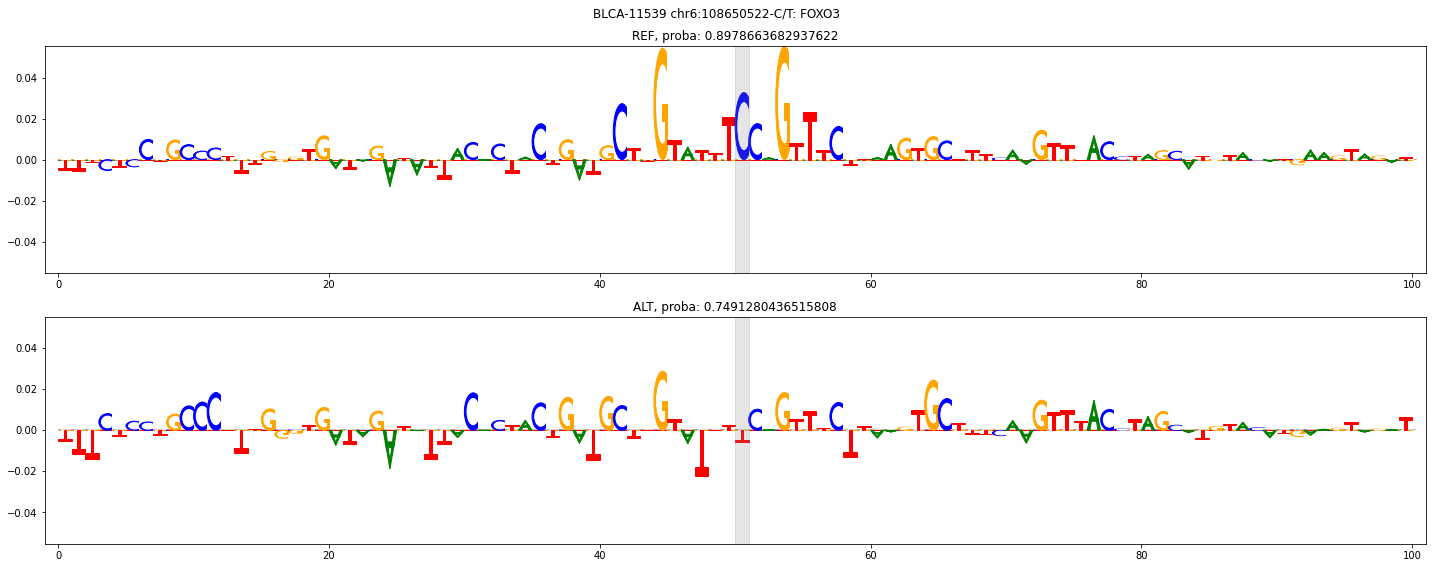

In [58]:
%matplotlib inline
plot_summit_centered(interest,
                     fasta_seq,
                     cancer_name,
                     model,
                     weights_files,
                     flank=50,
                     outdir=None,
                     mutation_in_middle=True)